https://webnautes.tistory.com/1658

In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

import xgboost
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

# 시드 고정

In [2]:
CFG = {
    'SEED':42
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED'])

# Load Data

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train = train_data.drop(['TARGET'], axis=1)
train_labels = train_data['TARGET']

display(train_data.head(3))
display(test_data.head(3))
display(train.head(3))
display(train_labels)

,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET
0,TRAIN_00000,9,화요일,10,137,8.0,2.611124,0.0,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2
1,TRAIN_00001,11,화요일,6,438,13.0,3.209093,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0
2,TRAIN_00002,8,일요일,6,1729,47.0,1.619597,0.0,0.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,인도,1


,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지
0,TEST_00000,9,금요일,5,927,28.0,1.570654,19.625000,0.0,0.0,165.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,차도
1,TEST_00001,5,수요일,3,926,28.0,1.712457,21.444444,0.0,0.0,175.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,식당
2,TEST_00002,5,월요일,6,1437,33.0,0.447496,25.200000,0.0,0.0,290.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,주거지


,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지
0,TRAIN_00000,9,화요일,10,137,8.0,2.611124,0.0,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도
1,TRAIN_00001,11,화요일,6,438,13.0,3.209093,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도
2,TRAIN_00002,8,일요일,6,1729,47.0,1.619597,0.0,0.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,인도


0        2
1        0
2        1
3        1
4        2
        ..
84401    1
84402    0
84403    0
84404    1
84405    0
Name: TARGET, Length: 84406, dtype: int64

# EDA

NameError: name 'sns' is not defined

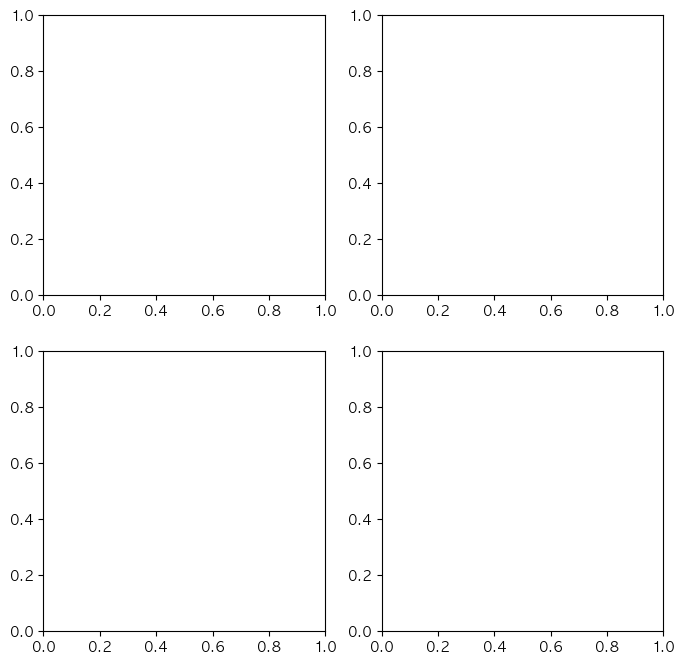

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

features = ['월', '요일', '시간', '범죄발생지']
for i, feature in enumerate(features):
    sns.barplot(data=train_data, x=feature, y='TARGET', ax=axes[i])
        
plt.show()

# Pipe line

In [ ]:
# 1. ID Drop하기
# 2. ['월', '요일', '시간', '범죄발생지']를 OneHotEncoder

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

class ID_Dropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        return X.drop('ID', axis=1)

class Features_OHE(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X_OHE = pd.get_dummies(X[['월', '요일', '시간', '범죄발생지']])
        X = pd.concat([X, X_OHE], axis=1)
        return X.drop(['월', '요일', '시간', '범죄발생지'], axis=1)

In [6]:
final_pipeline = Pipeline([
    ('ID_Dropper', ID_Dropper()),
    ('Features_OHE', Features_OHE()),
])

final_pipeline

Pipeline(steps=[('ID_Dropper', ID_Dropper()), ('Features_OHE', Features_OHE())])

In [7]:
train_prepared = final_pipeline.fit_transform(train)

display(train_prepared.head(3))
display(train_labels)

,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,...,범죄발생지_약국,범죄발생지_은행,범죄발생지_인도,범죄발생지_주거지,범죄발생지_주유소,범죄발생지_주차장,범죄발생지_차도,범죄발생지_편의점,범죄발생지_학교,범죄발생지_호텔/모텔
0,137,8.0,2.611124,0.0,0.0,0.0,245.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,438,13.0,3.209093,0.0,0.0,0.0,200.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2,1729,47.0,1.619597,0.0,0.0,0.0,40.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


0        2
1        0
2        1
3        1
4        2
        ..
84401    1
84402    0
84403    0
84404    1
84405    0
Name: TARGET, Length: 84406, dtype: int64

# Sample Weights

In [8]:
def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = y_train.unique()
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]

    return sample_weights

train_prepared_SW = CreateBalancedSampleWeights(train_labels, largest_class_weight_coef=1)
train_prepared_SW[:3]

[1.2473547319264644, 0.7718249069578178, 1.1078211337297057]

# Train Test Split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(train_prepared, train_labels,
                                                    test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(67524, 35) (16882, 35) (67524,) (16882,)


# Optuna

In [12]:
def objectigveXGB(trial):
    params = {
        'n_estimators':trial.suggest_int('n_estimators', 500, 10000),
        'max_depth':trial.suggest_int('max_depth', 8, 16),
        'min_child_weight':trial.suggest_int('min_child_weight', 1, 300),
        'gamma':trial.suggest_int('gamma', 1, 3),
        'learning_rate':trial.suggest_uniform('learning_rate', 0.0001, 0.01),
        'colsample_bytree':trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'n_jobs':-1,
        'alpha':trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'random_state':42,
     }
    
    model = XGBClassifier(**params)
    xgb_model = model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                          early_stopping_rounds=100, verbose=True)
    
    preds = xgb_model.predict(X_val)
    pred_labels = np.rint(preds)
    
    score = f1_score(pred_labels, y_val, average='macro')
    
    return score

In [ ]:
study = optuna.create_study(direction='maximize')

%time study.optimize(objectigveXGB, n_trials=3, show_progress_bar=True)

trial = study.best_trial

print("  Accuracy: {}".format(trial.value))
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-05-30 03:40:40,021] A new study created in memory with name: no-name-1082c71f-aaef-4692-8fc0-84330420ac0f


  0%|          | 0/3 [00:00<?, ?it/s]

[0]	validation_0-mlogloss:1.09835
[1]	validation_0-mlogloss:1.09809
[2]	validation_0-mlogloss:1.09779
[3]	validation_0-mlogloss:1.09752
[4]	validation_0-mlogloss:1.09723
[5]	validation_0-mlogloss:1.09698
[6]	validation_0-mlogloss:1.09670
[7]	validation_0-mlogloss:1.09642
[8]	validation_0-mlogloss:1.09617
[9]	validation_0-mlogloss:1.09590
[10]	validation_0-mlogloss:1.09562
[11]	validation_0-mlogloss:1.09536
[12]	validation_0-mlogloss:1.09508
[13]	validation_0-mlogloss:1.09481
[14]	validation_0-mlogloss:1.09457
[15]	validation_0-mlogloss:1.09435
[16]	validation_0-mlogloss:1.09414
[17]	validation_0-mlogloss:1.09387
[18]	validation_0-mlogloss:1.09363
[19]	validation_0-mlogloss:1.09334
[20]	validation_0-mlogloss:1.09307
[21]	validation_0-mlogloss:1.09281
[22]	validation_0-mlogloss:1.09257
[23]	validation_0-mlogloss:1.09237
[24]	validation_0-mlogloss:1.09212
[25]	validation_0-mlogloss:1.09185
[26]	validation_0-mlogloss:1.09166
[27]	validation_0-mlogloss:1.09139
[28]	validation_0-mlogloss:1.0

[231]	validation_0-mlogloss:1.05054
[232]	validation_0-mlogloss:1.05038
[233]	validation_0-mlogloss:1.05021
[234]	validation_0-mlogloss:1.05003
[235]	validation_0-mlogloss:1.04984
[236]	validation_0-mlogloss:1.04971
[237]	validation_0-mlogloss:1.04953
[238]	validation_0-mlogloss:1.04937
[239]	validation_0-mlogloss:1.04917
[240]	validation_0-mlogloss:1.04899
[241]	validation_0-mlogloss:1.04882
[242]	validation_0-mlogloss:1.04866
[243]	validation_0-mlogloss:1.04849
[244]	validation_0-mlogloss:1.04832
[245]	validation_0-mlogloss:1.04816
[246]	validation_0-mlogloss:1.04800
[247]	validation_0-mlogloss:1.04785
[248]	validation_0-mlogloss:1.04769
[249]	validation_0-mlogloss:1.04755
[250]	validation_0-mlogloss:1.04739
[251]	validation_0-mlogloss:1.04723
[252]	validation_0-mlogloss:1.04708
[253]	validation_0-mlogloss:1.04695
[254]	validation_0-mlogloss:1.04678
[255]	validation_0-mlogloss:1.04662
[256]	validation_0-mlogloss:1.04648
[257]	validation_0-mlogloss:1.04631
[258]	validation_0-mlogloss: